## dataload

In [24]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import eli5
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from eli5.sklearn import PermutationImportance
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'lgbm_other_features.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 62), (1974, 62), (260114, 62))

((1845539, 61), (1845539, 1), (1974, 61), (1974, 1))

In [30]:
max(df.solvesec_y)

5469902.5

In [25]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec_x', 'solvesec_3600',
       'time_category', 'solvesec_cumsum', 'solvecumsum_category',
       'big_category_cumconut', 'big_category_answer',
       'big_category_user_cum_acc', 'mid_category_cumconut',
       'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean',
       'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty',
       'pb_num_acc_std', 'assess_count', 'left_asymptote',
       'elo_assessmentItemID', 'elo_problem_num', 'user_tag_cluster',
       'tag_cluster', 'elo_big_category', 'elo_mid_category',
       'elo_user_tag_cluster', 'elo_tag_

## Params

([0, 2, 3, 9, 13, 14, 20],
 '🌈(12/07 Wed)[LGBM] 피처 추가: 21개',
 '사용된 피처(21)\nKnowledgeTag, user_mean_acc, assIdx, big_category, big_category_acc, big_category_acc_category, user_acc, user_correct_answer, day, time_category, solvesec_3600, elo_assessmentItemID, hour, month, problem_num, user_acc_rolling_mean_10, assess_count, user_tag_cluster, tag_count, userID, dayname')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.838032	valid's auc: 0.825617
[200]	train's auc: 0.841749	valid's auc: 0.82921
[300]	train's auc: 0.844514	valid's auc: 0.83151
[400]	train's auc: 0.846513	valid's auc: 0.833183
[500]	train's auc: 0.847953	valid's auc: 0.834339
[600]	train's auc: 0.849022	valid's auc: 0.835157
[700]	train's auc: 0.849898	valid's auc: 0.836058
[800]	train's auc: 0.850653	valid's auc: 0.836651
[900]	train's auc: 0.851268	valid's auc: 0.837293
[1000]	train's auc: 0.851818	valid's auc: 0.837803
[1100]	train's auc: 0.852326	valid's auc: 0.838373
[1200]	train's auc: 0.8528	valid's auc: 0.838807
[1300]	train's auc: 0.853221	valid's auc: 0.8390

2022/12/07 02:06:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2528d6d3d0f149d79c1efd10b3e40885. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

VALID AUC : 0.8413342056320876 ACC : 0.7710233029381965

model3_run_id='2528d6d3d0f149d79c1efd10b3e40885'
writing prediction : output/12_07_Wed_LGBM_피처_추가_21개.csv


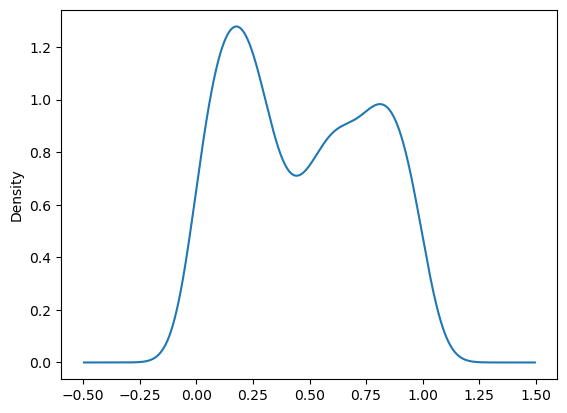

In [31]:
# TODO : tunning
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}

model = lgb.LGBMClassifier(
    **params,
    n_estimators=1000,
    silent=-1
)

### 피처 설정
# 사용할 Feature 설정
FEATS = [
     'KnowledgeTag',
     'user_mean_acc',
     'assIdx',
     'big_category',
     'big_category_acc',
     'big_category_acc_category',
    
     'user_acc',
     'user_correct_answer',
    
     'day',
     'time_category',
     'solvesec_3600',     
     'elo_assessmentItemID',
     'hour',
     'month',
     'problem_num',
     'user_acc_rolling_mean_10',    
     'assess_count',
     "user_tag_cluster",
     'tag_count',    
     'userID',
    
     'dayname',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM] 피처 1000 epochs: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
mlflow.sklearn.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model.fit(
        X=x_train[FEATS],
        y=y_train,
        early_stopping_rounds=100,
        eval_set=[(x_train[FEATS], y_train), (x_valid[FEATS], y_valid)],
        eval_names=["train",'valid'],
        eval_metric="roc_auc",
        verbose=100,
    )
    preds = model.predict_proba(x_valid[FEATS])[:,1]
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [37]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7831
run_id = '2528d6d3d0f149d79c1efd10b3e40885'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 2528d6d3d0f149d79c1efd10b3e40885


In [20]:
perm = PermutationImportance(
    model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
).fit(x_valid[FEATS], y_valid)
eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)
perm_imp_df = pd.DataFrame()
perm_imp_df["feature"] = FEATS
perm_imp_df["importance"] = perm.feature_importances_
perm_imp_df["std"] = perm.feature_importances_std_
perm_imp_df.sort_values(by="importance", ascending=False, inplace=True)
perm_imp_df.reset_index(drop=True, inplace=True)
perm_imp_df

Weight,Feature
0.2086 ± 0.0000,elo_assessmentItemID
0.0534 ± 0.0000,big_category_user_cum_acc
0.0515 ± 0.0000,solvesec_3600
0.0220 ± 0.0000,assIdx
0.0191 ± 0.0000,user_mean_acc
0.0071 ± 0.0000,time_category
0.0037 ± 0.0000,userID
0.0019 ± 0.0000,user_acc
0.0009 ± 0.0000,big_category_cumconut
0.0005 ± 0.0000,user_tag_cluster


,feature,importance,std
0,elo_assessmentItemID,0.208598,0.0
1,big_category_user_cum_acc,0.053417,0.0
2,solvesec_3600,0.051522,0.0
3,assIdx,0.021997,0.0
4,user_mean_acc,0.019094,0.0
5,time_category,0.007065,0.0
6,userID,0.003723,0.0
7,user_acc,0.001912,0.0
8,big_category_cumconut,0.000891,0.0
9,user_tag_cluster,0.000549,0.0


In [13]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8185
run_id = '5c679883be5f4a65a06aacef5671d156'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 5c679883be5f4a65a06aacef5671d156


## user_acc_rolling_mean_10_big_category_관련_피처_추가

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31, 34],
 '🌈(12/07 Wed)[LGBM user_acc_rolling_mean_10, big_category 관련 피처 추가 lr 0.023] 피처: 35개',
 '사용된 피처(35)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, user_tag_cluster, user_acc_rolling_mean_10, big_category_acc, big_category_acc_category')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20538
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.520431
[200]	valid_0's binary_logloss: 0.502625
[300]	valid_0's binary_logloss: 0.497136
[400]	valid_0's binary_logloss: 0.494068
[500]	valid_0's binary_logloss: 0.491752
[600]	valid_0's binary_logloss: 0.490237
[700]	valid_0's binary_logloss: 0.488646
[800]	valid_0's binary_logloss: 0.487044
[900]	valid_0's binary_logloss: 0.485485
[100

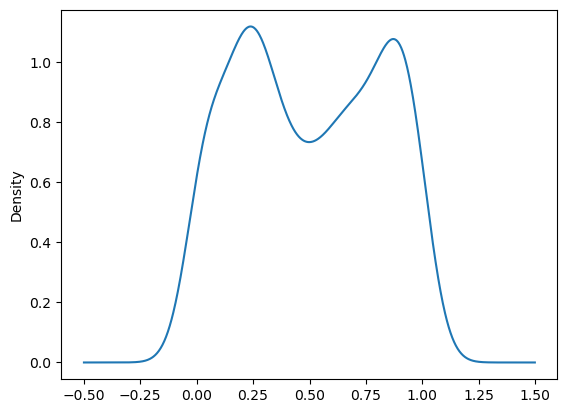

In [32]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'user_tag_cluster',
         'user_acc_rolling_mean_10',
         'big_category_acc',
         'big_category_acc_category',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category','big_category_acc_category',
             'problem_num','dayname','month','time_category','solvecumsum_category','user_tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_acc_rolling_mean_10, big_category 관련 피처 추가 lr 0.023] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model3.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [35]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8015
run_id = '3be9e9bb7f014138b80aa2567096febd'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 3be9e9bb7f014138b80aa2567096febd


### 1000epoch

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23, 31, 34],
 '🌈(12/07 Wed)[LGBM user_acc_rolling_mean_10, big_category 관련 피처 추가 lr 0.023 1000epoch] 피처: 35개',
 '사용된 피처(35)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, user_tag_cluster, user_acc_rolling_mean_10, big_category_acc, big_category_acc_category')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20538
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.520431
[200]	valid_0's binary_logloss: 0.502625
[300]	valid_0's binary_logloss: 0.497136
[400]	valid_0's binary_logloss: 0.494068
[500]	valid_0's binary_logloss: 0.491752
[600]	valid_0's binary_logloss: 0.490237
[700]	valid_0's binary_logloss: 0.488646
[800]	valid_0's binary_logloss: 0.487044
[900]	valid_0's binary_logloss: 0.485485
[100

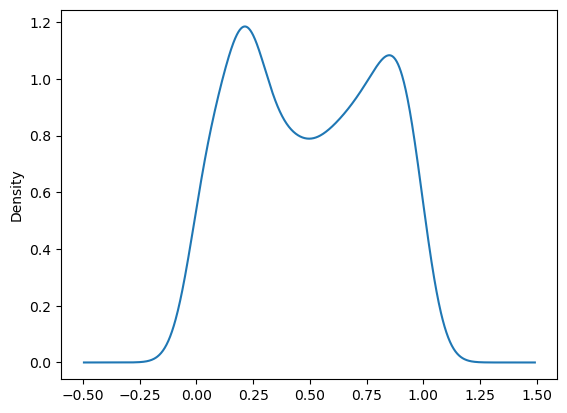

In [33]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'user_tag_cluster',
         'user_acc_rolling_mean_10',
         'big_category_acc',
         'big_category_acc_category',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category','big_category_acc_category',
             'problem_num','dayname','month','time_category','solvecumsum_category','user_tag_cluster']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_acc_rolling_mean_10, big_category 관련 피처 추가 lr 0.023 1000epoch] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=1000,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [36]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8059
run_id = '43cbb2ec66524342bd471368a22bf94a'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 43cbb2ec66524342bd471368a22bf94a


<AxesSubplot:xlabel='bins'>

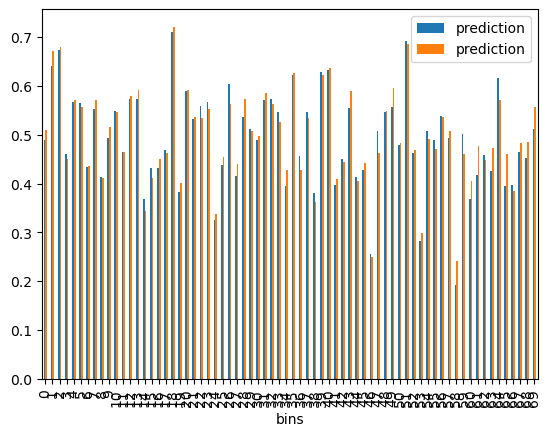

In [34]:
bins=70

auc819 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_elo만_추가_lr_0_023_피처_32개.csv')
auc819['bins'] = pd.cut(auc819.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc819.bins.unique()))}
auc819['bins'] = auc819.bins.map(bins_map)
auc819_grp = auc819.groupby('bins').prediction.mean()

user_dfc2 = pd.read_csv('../LGBM/output/12_07_Wed_LGBM_user_acc_rolling_mean_10_big_category_관련_피처_추가_lr_0_023_1000epoch_피처_35개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc2_grp],axis=1).plot(kind='bar')